In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
import numpy as np

In [ ]:
!pip install nltk

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load the data
Data = pd.read_excel("/content/drive/MyDrive/Thesis/Product Review Sentiment Analysis.xlsx")

In [ ]:
print(Data)

                                                Reviews Sentiments
0     লটির পো ) ভালোই প্রথম দিনেই বেশ বড় সাইজের একটা...  Negative 
1     এদের কাছ থেকে প্রডাক্ট নেওয়ার থেকে বাড়া  নিজে ...  Negative 
2     অডার করছিলাম ৪ বা ৫ তারিখ হতে বাড়া  পারে তার প...  Negative 
3                     হারামজাদা | বক্স ভিজা ছিল বাড়া  `  Negative 
4        বোতলের মুখ ভাংগা ছিল পুরাই ফালতু _ হারামজাদা -  Negative 
...                                                 ...        ...
3567  আলহামদুলিল্লাহ = বীজ সঠিক সময়ে হাতে পেয়েছি ভাল...   Positive
3568  যা ভেবেছিলাম তারচেয়ে অনেক ভালো ধন্যবাদ  আমার ভ...   Positive
3569  ভালোই ছিলো প্যাকেজিং ১০ টা ম্যাস্ক ছিলো সিল দে...   Positive
3570                   খুব ভালো মানের মাক্স  অসাধারণ  :   Positive
3571    চোখ বন্ধ করে কিনে ফালান অনেক ভালো  খুবই ভালো  +   Positive

[3572 rows x 2 columns]


<ipython-input-7-79b6d9e1af22>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiments', data=Data, palette=colors.values())  # Pass values of the colors dictionary


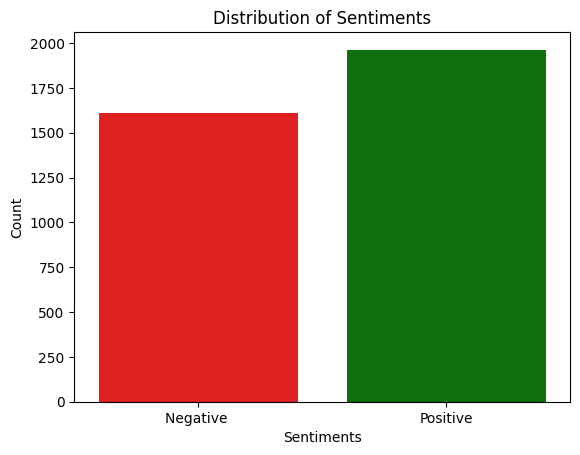

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette
colors = {'negative': 'red', 'positive': 'green'}

# Plot the count of sentiments with specified palette
sns.countplot(x='Sentiments', data=Data, palette=colors.values())  # Pass values of the colors dictionary

# Set labels and title
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')

# Show the plot
plt.show()

In [ ]:
# Preprocessing Text
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    # Remove single characters
    text = ' '.join([word for word in text.split() if len(word) > 1])
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove leading and trailing spaces
    text = text.strip()
    return text

Data['Reviews'] = Data['Reviews'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)

Data['Sentiments'] = Data['Sentiments'].str.lower()
print(Data)

                                                Reviews Sentiments
0     লটির পো ভালোই প্রথম দিনেই বেশ বড় সাইজের একটা ধ...  negative 
1     এদের কাছ থেকে প্রডাক্ট নেওয়ার থেকে বাড়া নিজে গ...  negative 
2     অডার করছিলাম বা তারিখ হতে বাড়া পারে তার পরে ক্...  negative 
3                          হারামজাদা বক্স ভিজা ছিল বাড়া  negative 
4            বোতলের মুখ ভাংগা ছিল পুরাই ফালতু হারামজাদা  negative 
...                                                 ...        ...
3567  আলহামদুলিল্লাহ বীজ সঠিক সময়ে হাতে পেয়েছি ভালোই...   positive
3568  যা ভেবেছিলাম তারচেয়ে অনেক ভালো ধন্যবাদ আমার ভা...   positive
3569  ভালোই ছিলো প্যাকেজিং  টা ম্যাস্ক ছিলো সিল দেয়া...   positive
3570                       খুব ভালো মানের মাক্স অসাধারণ   positive
3571        চোখ বন্ধ করে কিনে ফালান অনেক ভালো খুবই ভালো   positive

[3572 rows x 2 columns]


In [ ]:
# Remove Bangla stopwords
bangla_stopwords = [
    'এই', 'সে', 'এ', 'তার', 'যে', 'আমাদের', 'তাদের', 'আমরা', 'তোমরা',
    'তুমি', 'তারা', 'যার', 'কোন', 'কিছু', 'এক', 'অনেক', 'অধিক', 'সব',
    'কত', 'কোথায়']
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in bangla_stopwords]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

Data['Cleaned_Reviews'] = Data['Reviews'].apply(remove_stopwords)
from gensim.models import Word2Vec

print(Data)


                                                Reviews Sentiments  \
0     লটির পো ভালোই প্রথম দিনেই বেশ বড় সাইজের একটা ধ...  negative    
1     এদের কাছ থেকে প্রডাক্ট নেওয়ার থেকে বাড়া নিজে গ...  negative    
2     অডার করছিলাম বা তারিখ হতে বাড়া পারে তার পরে ক্...  negative    
3                          হারামজাদা বক্স ভিজা ছিল বাড়া  negative    
4            বোতলের মুখ ভাংগা ছিল পুরাই ফালতু হারামজাদা  negative    
...                                                 ...        ...   
3567  আলহামদুলিল্লাহ বীজ সঠিক সময়ে হাতে পেয়েছি ভালোই...   positive   
3568  যা ভেবেছিলাম তারচেয়ে অনেক ভালো ধন্যবাদ আমার ভা...   positive   
3569  ভালোই ছিলো প্যাকেজিং  টা ম্যাস্ক ছিলো সিল দেয়া...   positive   
3570                       খুব ভালো মানের মাক্স অসাধারণ   positive   
3571        চোখ বন্ধ করে কিনে ফালান অনেক ভালো খুবই ভালো   positive   

                                        Cleaned_Reviews  
0     লটির পো ভালোই প্রথম দিনেই বেশ বড় সাইজের একটা ধ...  
1     এদের কাছ থেকে প্রডাক্ট নেওয়ার থেকে বা

In [ ]:
# Tokenization
def tokenize_text(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    tokens = word_tokenize(text)
    return tokens

Data['Tokenized_Reviews'] = Data['Reviews'].apply(lambda x: tokenize_text(x) if pd.notnull(x) else x)

# Remove null values
Data = Data.dropna(subset=['Tokenized_Reviews'])
print(Data)

                                                Reviews Sentiments  \
0     লটির পো ভালোই প্রথম দিনেই বেশ বড় সাইজের একটা ধ...  negative    
1     এদের কাছ থেকে প্রডাক্ট নেওয়ার থেকে বাড়া নিজে গ...  negative    
2     অডার করছিলাম বা তারিখ হতে বাড়া পারে তার পরে ক্...  negative    
3                          হারামজাদা বক্স ভিজা ছিল বাড়া  negative    
4            বোতলের মুখ ভাংগা ছিল পুরাই ফালতু হারামজাদা  negative    
...                                                 ...        ...   
3567  আলহামদুলিল্লাহ বীজ সঠিক সময়ে হাতে পেয়েছি ভালোই...   positive   
3568  যা ভেবেছিলাম তারচেয়ে অনেক ভালো ধন্যবাদ আমার ভা...   positive   
3569  ভালোই ছিলো প্যাকেজিং  টা ম্যাস্ক ছিলো সিল দেয়া...   positive   
3570                       খুব ভালো মানের মাক্স অসাধারণ   positive   
3571        চোখ বন্ধ করে কিনে ফালান অনেক ভালো খুবই ভালো   positive   

                                        Cleaned_Reviews  \
0     লটির পো ভালোই প্রথম দিনেই বেশ বড় সাইজের একটা ধ...   
1     এদের কাছ থেকে প্রডাক্ট নেওয়ার থেকে 

In [ ]:
# Remove null values
Data = Data.dropna(subset=['Tokenized_Reviews'])

# Prepare data for Word2Vec
tokenized_text = Data['Tokenized_Reviews'].tolist()

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)
model.train(tokenized_text, total_examples=len(tokenized_text), epochs=10)

# Save the trained Word2Vec model
model.save("word2vec_model")

In [ ]:
# Label Encoding for Sentiments
y = Data['Sentiments']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split data into train and test sets
X = Data['Reviews']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Tokenize text
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# Convert text to sequences and pad them
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


In [ ]:
max_sequence_length = max([len(seq) for seq in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')


In [ ]:
# Build the BiLSTM model
embedding_dim = 200  # Should match the vector size in Word2Vec model

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Change the dtype of X_train_padded to float64
X_train_padded = X_train_padded.astype(np.float64)

# Train the model
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
81/81 [==============================] - 82s 1s/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.0082 - val_accuracy: 0.9965
Epoch 2/20
81/81 [==============================] - 51s 636ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 0.9965
Epoch 3/20
81/81 [==============================] - 53s 650ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9965
Epoch 4/20
81/81 [==============================] - 56s 697ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9965
Epoch 5/20
81/81 [==============================] - 54s 666ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9965
Epoch 6/20
81/81 [==============================] - 53s 655ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9965
Epoch 7/20
81/81 [==============================] - 52s 639ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9965
Ep

In [ ]:
# Evaluate the model
X_test_padded = X_test_padded.astype(np.float64)  # Change dtype to float64
loss, accuracy = model.evaluate(X_test_padded, y_test)
print("Test Accuracy:", accuracy)

23/23 [==============================] - 2s 76ms/step - loss: 0.0247 - accuracy: 0.9958
Test Accuracy: 0.9958041906356812


34/34 [==============================] - 5s 125ms/step


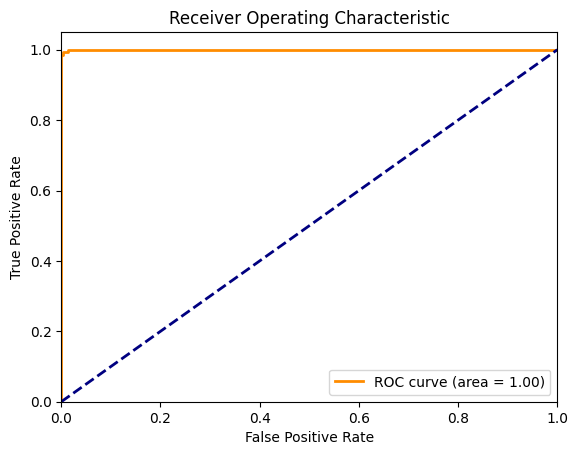

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the test set
y_pred_prob = model.predict(X_test_padded)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Get predicted probabilities for the test set
y_pred_prob = model.predict(X_test_padded)

# Convert probabilities to binary classes
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Flatten binary predictions if needed
y_pred_binary = y_pred_binary.flatten()

# Compute performance measures
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)



34/34 [==============================] - 4s 125ms/step
Accuracy: 0.9944029850746269
Precision: 0.9946996466431095
Recall: 0.9946996466431095
F1-score: 0.9946996466431095
Confusion Matrix:
[[503   3]
 [  3 563]]


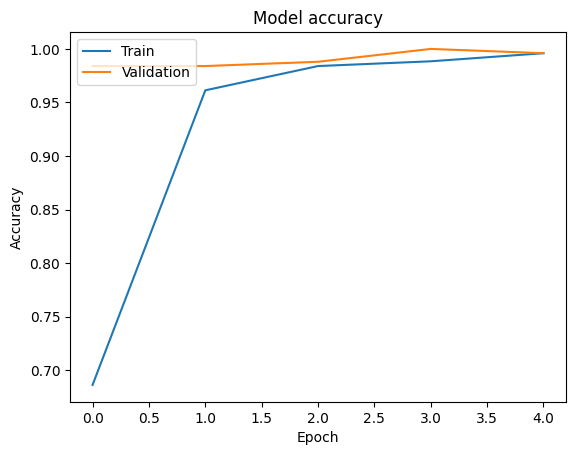

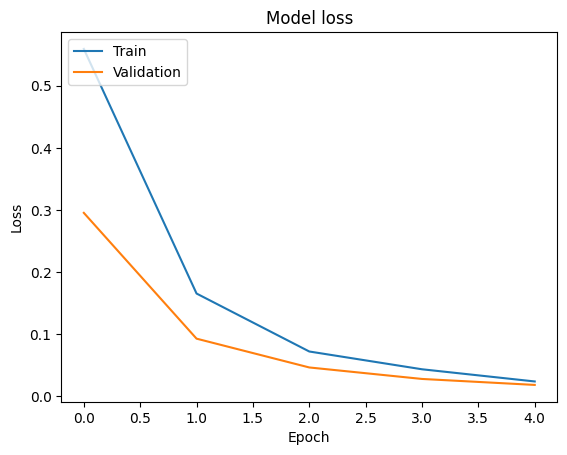

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()